# Setup

In [1]:
# Data libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
eurostoxx_original = pd.read_csv("eurostoxx.csv", low_memory=False)
eurostoxx_isin = pd.read_csv("eurostoxx_ISINs.csv")
trucost = pd.read_csv("07062024_Cushon_Trucost_Data.csv")
isin_summary = pd.read_csv("isin_summary.csv", low_memory=False)
index_price = pd.read_csv("EuroSTOXX600 Historical Price Data.csv")
eurostoxx_sectors = pd.read_csv("Euro Stoxx 600 Data.csv")

# Data cleaning

In [3]:
# Data cleaning
# for eurostoxx_original
eurostoxx_original.columns = ['Date'] + list(eurostoxx_original.columns[1:]) #rename the columns
eurostoxx_original = eurostoxx_original.drop(index=0) #drop the first row
eurostoxx_original = eurostoxx_original.melt(id_vars=['Date'],var_name='Ticker',value_name='Price') #transformation
eurostoxx_original['Price'] = pd.to_numeric(eurostoxx_original['Price'], errors='coerce') #convert to numeric
eurostoxx_original['Date'] = pd.to_datetime(eurostoxx_original['Date']) #convert to datetime format

# for isin_summary
isin_summary.columns = ['ISIN'] + list(isin_summary.columns[1:]) #rename the columns

# for index_price
index_price['Date'] = pd.to_datetime(index_price['Date'], format='%d/%m/%Y') #convert to datetime format
index_price['Eurostoxx600 %'] = index_price['Change %'].str.replace('%', '').astype(float) #convert to numeric

# Filter companies in scope of EU ETS

EU ETS Scope Description (sourced from the EU ETS website):
* Electricity and heat generation
* Energy-intensive industry sectors, including oil refineries, steel works, and production of iron, aluminium, metals, cement, lime, glass, ceramics, pulp, paper, cardboard, acids and bulk organic chemicals
* Aviation within the European Economic Area and departing flights to Switzerland and the United Kingdom
* Maritime transport, specifically 50% of emissions from voyages starting or ending outside of the EU and 100% of emissions from voyages between two EU ports and when ships are within EU ports. 

Given that `'Industrials'` is a broad sector that likely encompasses segments mentioned in the EU ETS description, the more detailed sector classifications `'GICS 2'` in `eurostoxx_sectors` are used to identify specific segments that fall within the scope of the EU ETS.

Segments Likely in Scope of EU ETS:
* `Energy`: Directly involves energy production, including electricity and heat, which are core to the EU ETS.
* `Utilities`: Generally includes companies involved in the generation, transmission, and distribution of electricity.
* `Materials`: This can include sectors like cement, chemicals, steel, and other heavy industries that are energy-intensive.
* `Transportation`: This includes airlines covered by the system.

In [4]:
# List of sectors within the scope of EU ETS
sectors_in_scope = ['Energy', 'Utilities', 'Materials', 'Transportation']
# Filter companies in scope of EU ETS
filtered_companies = eurostoxx_sectors[eurostoxx_sectors['GICS 2'].isin(sectors_in_scope)]['ISIN']

In [5]:
filtered_companies

2      SE0020050417
5      AT0000831706
6      LU2290522684
11     GB0007188757
15     GB00B1XZS820
           ...     
584    GB00B1FH8J72
591    DE0006766504
592    SE0011090018
595    CH0319416936
597    JE00B4T3BW64
Name: ISIN, Length: 114, dtype: object

# Merge data

In [6]:
# Merge eurostoxx_original and eurostoxx_isin on 'Ticker'
eurostoxx = pd.merge(eurostoxx_original, eurostoxx_isin, on='Ticker', how='inner').drop(columns='Ticker')

# Merge eurostoxx with eurostoxx_sectors
eurostoxx = eurostoxx.merge(eurostoxx_sectors[['ISIN', 'GICS 1']], on='ISIN', how='left').rename(
                                                                                      columns={'GICS 1': 'Sector'})

# Create a 'LaggedYear' column in eurostoxx for merging with 'FISCAL_YEAR' in trucost
eurostoxx['LaggedYear'] = eurostoxx['Date'].dt.year - 1

# Calculate daily return
eurostoxx['Return %'] = eurostoxx.groupby('ISIN')['Price'].pct_change()*100

In [7]:
# Merge eurostoxx and trucost (emission data) on 'ISIN' and 'LaggedYear'
d = pd.merge(eurostoxx, trucost, left_on=['ISIN', 'LaggedYear'], right_on=['ISIN', 'FISCAL_YEAR'], how='inner')

# Merge d with index_price to include market changes in the regression analysis and drop repeated columns
d = d.merge(index_price[['Date', 'Eurostoxx600 %']], on='Date', how='left').drop(columns=['COMPANY_NAME', 
                                                                                    'FISCAL_YEAR', 'LaggedYear'])

# Drop the rows with missing values
d = d.dropna()

In [8]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870759 entries, 1 to 889699
Data columns (total 15 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   Date                                     870759 non-null  datetime64[ns]
 1   Price                                    870759 non-null  float64       
 2   ISIN                                     870759 non-null  object        
 3   Name                                     870759 non-null  object        
 4   Sector                                   870759 non-null  object        
 5   Return %                                 870759 non-null  float64       
 6   CARBON_SCOPE_1                           870759 non-null  float64       
 7   CARBON_INTENSITY_SCOPE_1_USD             870759 non-null  float64       
 8   CARBON_SCOPE_2                           870759 non-null  float64       
 9   CARBON_INTENSITY_SCOPE_2_U

In [9]:
# Filter for in and out of scope companies
d_in = d[d['ISIN'].isin(filtered_companies)]
d_out = d[~d['ISIN'].isin(filtered_companies)]

In [10]:
len(d['ISIN'].unique())

584

The emission data `trucost` covers 584 companies out of the 600 companies in Eurostoxx, missing data from 16 companies, of which 3 are filtered companies.

The missing 16 companies are:

In [11]:
eurostoxx_isin[~eurostoxx_isin['ISIN'].isin(d['ISIN'].unique())][['ISIN', 'Name']]

,ISIN,Name
6,LU2290522684,InPost SA
70,GB00B17BBQ50,Investec PLC
86,CH1169360919,Accelleron Industries AG
98,DE000PAG9113,Dr Ing hc F Porsche AG
159,NL0015000LU4,Iveco Group NV
250,SE0005127818,Sagax AB
322,CH1243598427,Sandoz Group AG
342,SE0000107203,Industrivarden AB
424,SE0001174970,Millicom International Cellular SA
432,SE0021921269,Saab AB


# Exploratory Data Analysis

In [12]:
def plot_histograms(df, columns, bins=50):
    num_columns = 2
    num_rows = (len(columns) + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(14, 3 * num_rows))

    for i, column in enumerate(columns):
        row, col = divmod(i, num_columns)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.hist(df[column].dropna(), bins=bins, edgecolor='k', alpha=0.7)
        ax.set_title(f'Histogram of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True)

    # Remove empty subplots if the number of columns is odd
    if len(columns) % num_columns != 0:
        fig.delaxes(axes[num_rows-1, -1])

    plt.tight_layout()
    plt.show()

In [13]:
# List of columns to plot histograms for
columns_to_plot = [
    'CARBON_SCOPE_1', 'CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_SCOPE_2', 'CARBON_INTENSITY_SCOPE_2_USD', 
    'CARBON_SCOPE_3_UPSTREAM', 'CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD', 'CARBON_SCOPE_3_DOWNSTREAM',
    'CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD', 'Eurostoxx600 %', 'Return %'
]

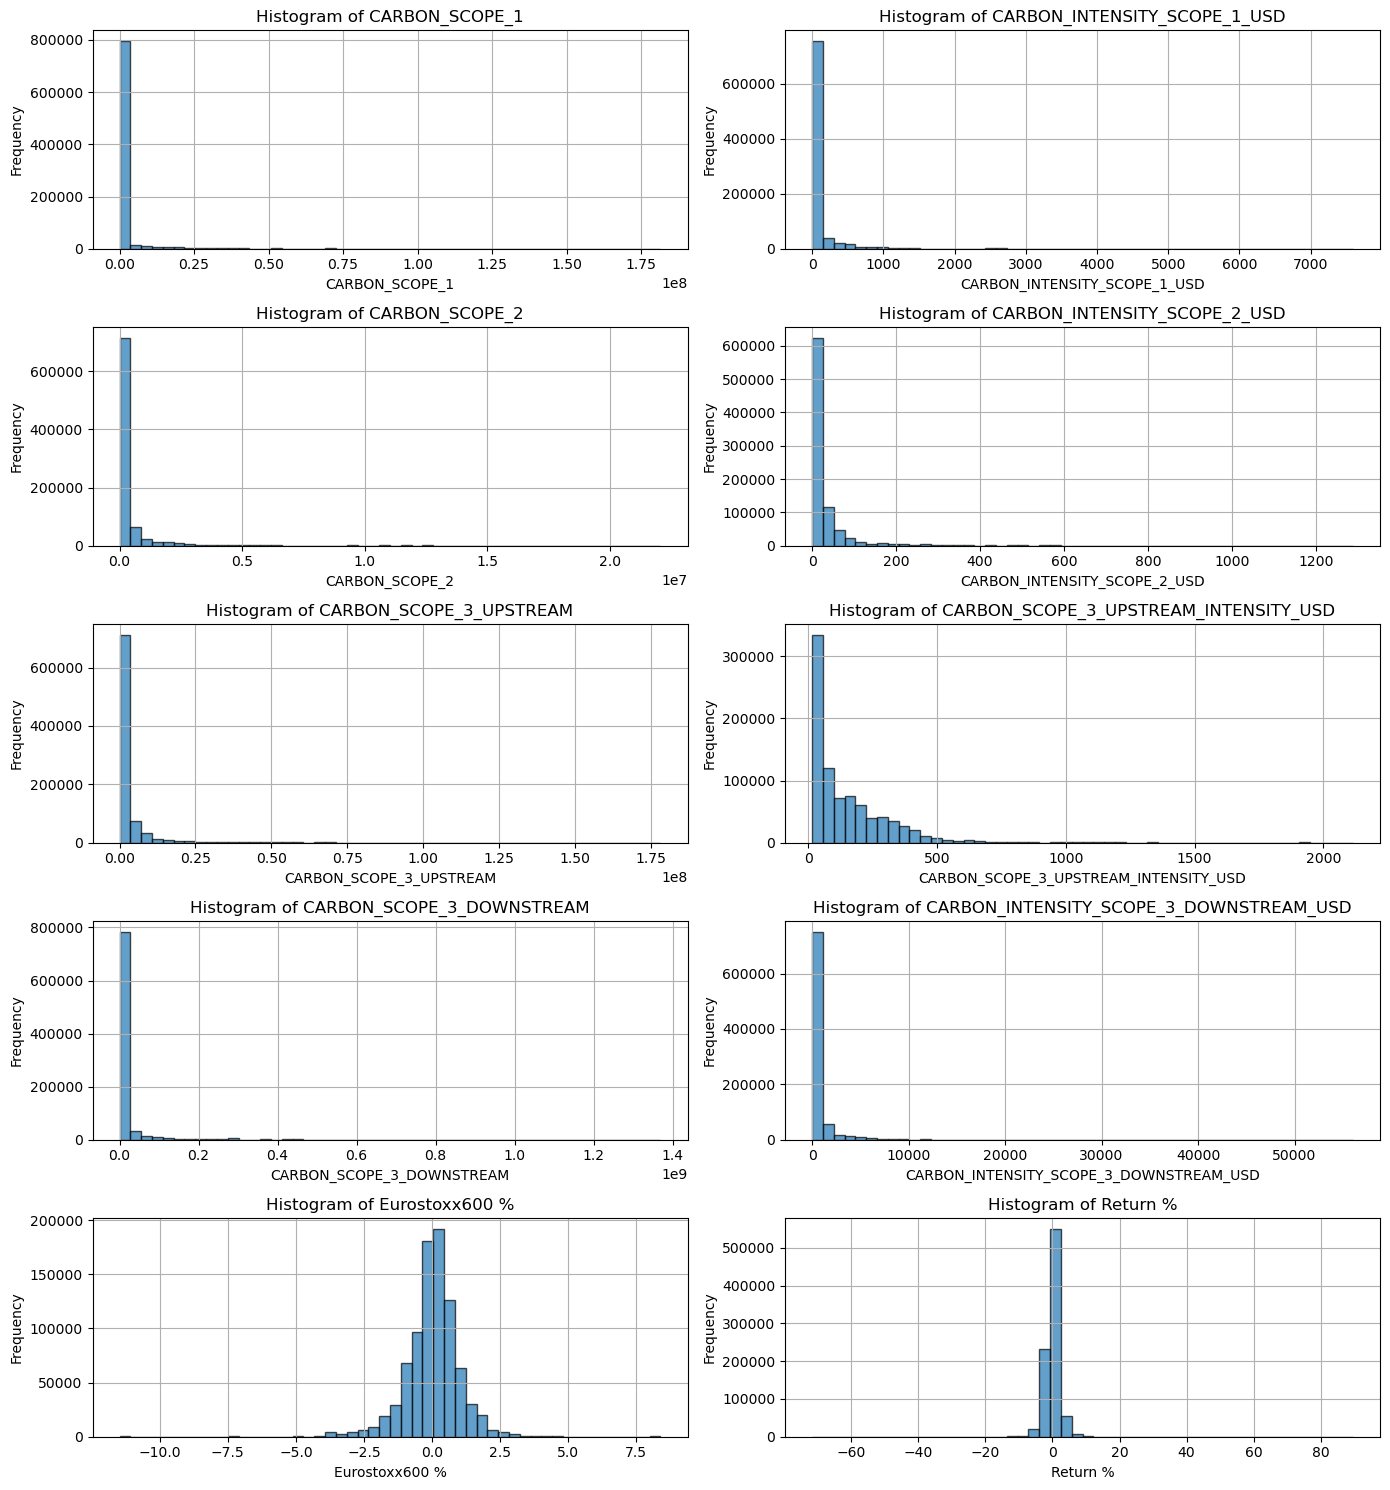

In [14]:
# Call the function to plot histograms
plot_histograms(d, columns_to_plot)

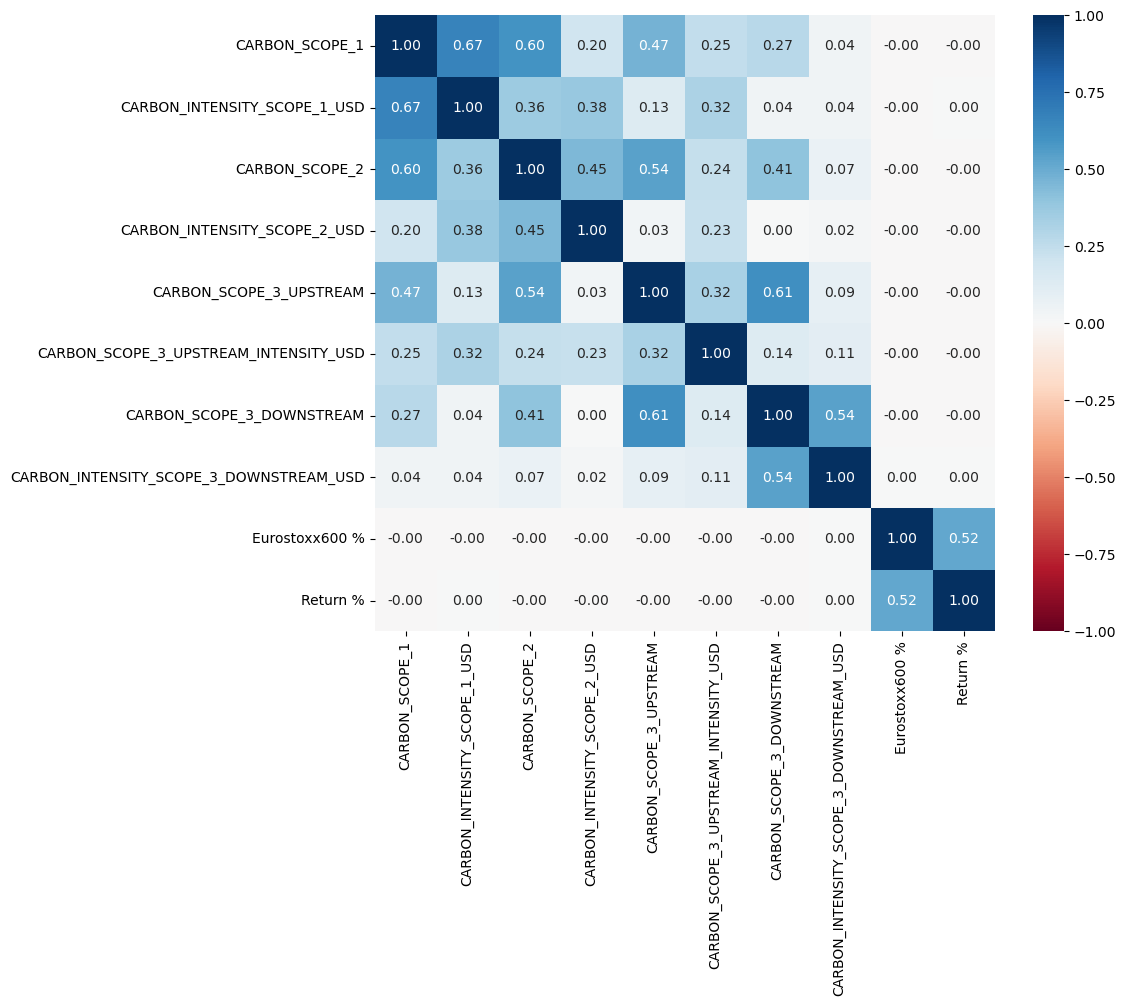

In [15]:
# Plot the correlation heatmap
corr = d[['CARBON_SCOPE_1', 'CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_SCOPE_2', 'CARBON_INTENSITY_SCOPE_2_USD', 
    'CARBON_SCOPE_3_UPSTREAM', 'CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD', 'CARBON_SCOPE_3_DOWNSTREAM',
    'CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD', 'Eurostoxx600 %', 'Return %']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='RdBu', fmt=".2f", vmin=-1, vmax=1)
plt.show()

# Regression

In [16]:
def regression(independent_variables, df):
    # Define X and y
    X = df[independent_variables]
    y = df['Return %']

    # Define preprocessing steps
    features_to_be_standardized = [col for col in independent_variables if col not in 'Sector']
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features_to_be_standardized),  #scaling specified numerical features
            ('onehot', OneHotEncoder(drop='first'), ['Sector'])      #one-hot encoding for 'Sector'
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Preprocess X
    X_processed = pipeline.fit_transform(X)

    # Get feature names after one-hot encoding
    onehot_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['Sector'])
    feature_names = features_to_be_standardized + list(onehot_feature_names)

    # Convert X_processed to DataFrame to handle feature names
    X_processed = pd.DataFrame(X_processed, index=X.index, columns=feature_names)

    # Add a constant for the intercept
    X_processed = sm.add_constant(X_processed)

    # Fit the OLS model
    model = sm.OLS(y, X_processed).fit()

    # Return the model summary
    return model.summary()

In [17]:
# Define independent variables
carbon_intensity = ['CARBON_INTENSITY_SCOPE_1_USD', 'CARBON_INTENSITY_SCOPE_2_USD', 
                    'CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD', 'CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD', 
                    'Eurostoxx600 %', 'Sector']

In [18]:
# Regression on all companies in Eurostoxx using carbon intensity data
summary_d = regression(carbon_intensity, d)
summary_d

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Return %   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                 2.107e+04
Date:                Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:36:05   Log-Likelihood:            -1.7408e+06
No. Observations:              870759   AIC:                         3.482e+06
Df Residuals:                  870743   BIC:                         3.482e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0134      0.008      1.574      0.115      -0.003       0.030
CARBON_INTENSITY_SCOPE_1_USD                0.0029      0.002      1.315      0.188      -0.001       0.007
CARBON_INTENSITY_SCOPE_2_USD                0.0013      0.002      0.603      0.547      -0.003       0.006
CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD      -0.0050      0.003     -1.967      0.049      -0.010    -1.7e-05
CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD     0.0019      0.002      0.949      0.342      -0.002       0.006
Eurostoxx600 %                              1.0763      0.002    562.137      0.000       1.073       1.080
Sector_Consumer Discretionary               0.0185      0.010      1.803      0.071      -0.002       0.039
Sector_Consumer Staples                     0.0185      0.012      1.593      0.111      -0.004       0.041
Sector_Energy                               0.0294      0.015      1.986      0.047       0.000       0.058
Sector_Financials                           0.0114      0.009      1.201      0.230      -0.007       0.030
Sector_Health Care                          0.0357      0.011      3.367      0.001       0.015       0.056
Sector_Industrials                          0.0266      0.010      2.785      0.005       0.008       0.045
Sector_Information Technology               0.0560      0.012      4.742      0.000       0.033       0.079
Sector_Materials                            0.0089      0.012      0.754      0.451      -0.014       0.032
Sector_Real Estate                          0.0013      0.012      0.109      0.913      -0.022       0.025
Sector_Utilities                            0.0153      0.012      1.276      0.202      -0.008       0.039
==============================================================================
Omnibus:                   261318.685   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         37332589.170
Skew:                           0.264   Prob(JB):                         0.00
Kurtosis:                      35.073   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Regression on filtered companies
summary_d_in = regression(carbon_intensity, d_in)
summary_d_in

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Return %   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     7622.
Date:                Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:36:06   Log-Likelihood:            -3.3266e+05
No. Observations:              167419   AIC:                         6.653e+05
Df Residuals:                  167410   BIC:                         6.654e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0504      0.012      4.160      0.000       0.027       0.074
CARBON_INTENSITY_SCOPE_1_USD                0.0119      0.005      2.391      0.017       0.002       0.022
CARBON_INTENSITY_SCOPE_2_USD                0.0020      0.005      0.414      0.679      -0.007       0.011
CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD      -0.0184      0.006     -3.103      0.002      -0.030      -0.007
CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD     0.0045      0.004      1.015      0.310      -0.004       0.013
Eurostoxx600 %                              1.0649      0.004    246.882      0.000       1.056       1.073
Sector_Industrials                         -0.0435      0.019     -2.248      0.025      -0.081      -0.006
Sector_Materials                           -0.0216      0.014     -1.593      0.111      -0.048       0.005
Sector_Utilities                           -0.0293      0.016     -1.822      0.068      -0.061       0.002
==============================================================================
Omnibus:                    34223.663   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1195185.261
Skew:                           0.161   Prob(JB):                         0.00
Kurtosis:                      16.085   Cond. No.                         8.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Regression on companies out of scope in the EU ETS
summary_d_out = regression(carbon_intensity, d_out)
summary_d_out

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Return %   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                 2.126e+04
Date:                Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:36:07   Log-Likelihood:            -1.4081e+06
No. Observations:              703340   AIC:                         2.816e+06
Df Residuals:                  703327   BIC:                         2.816e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.0139      0.008      1.635      0.102      -0.003       0.030
CARBON_INTENSITY_SCOPE_1_USD               -0.0014      0.002     -0.566      0.571      -0.006       0.003
CARBON_INTENSITY_SCOPE_2_USD                0.0012      0.002      0.503      0.615      -0.003       0.006
CARBON_SCOPE_3_UPSTREAM_INTENSITY_USD      -0.0016      0.003     -0.588      0.557      -0.007       0.004
CARBON_INTENSITY_SCOPE_3_DOWNSTREAM_USD     0.0005      0.002      0.215      0.830      -0.004       0.005
Eurostoxx600 %                              1.0789      0.002    505.036      0.000       1.075       1.083
Sector_Consumer Discretionary               0.0170      0.010      1.651      0.099      -0.003       0.037
Sector_Consumer Staples                     0.0143      0.012      1.205      0.228      -0.009       0.038
Sector_Financials                           0.0120      0.010      1.264      0.206      -0.007       0.031
Sector_Health Care                          0.0350      0.011      3.296      0.001       0.014       0.056
Sector_Industrials                          0.0288      0.010      2.941      0.003       0.010       0.048
Sector_Information Technology               0.0552      0.012      4.661      0.000       0.032       0.078
Sector_Real Estate                          0.0020      0.012      0.165      0.869      -0.022       0.025
==============================================================================
Omnibus:                   220846.461   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         38674082.449
Skew:                           0.288   Prob(JB):                         0.00
Kurtosis:                      39.323   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf Dissertation.ipynb

[NbConvertApp] Converting notebook Dissertation.ipynb to pdf
[NbConvertApp] Writing 340366 bytes to Dissertation.pdf
